In [15]:
import torch
import torch.nn as nn
import numpy as np
import sys
import os
import random
import matplotlib.pyplot as plt


src_path = "/projects/bcnx/kazumak2/MIMONet/src"
print("Using src path:", src_path)

if src_path not in sys.path:
    sys.path.append(src_path)

from utils import MIMONetDataset, DeepONetDataset, ChannelScaler
from mimonet import MIMONet, MIMONet_Transform

Using src path: /projects/bcnx/kazumak2/MIMONet/src


In [16]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [17]:
# set working directory
working_dir = "/projects/bcnx/kazumak2/MIMONet/LDC/"
data_dir = os.path.join(working_dir, "data")

## load datasets

### Load sharing parameters/dataset

In [18]:
# trunk dataset
trunk_input = np.load(os.path.join(data_dir, "share/coords.npy"))

### Training data

In [19]:
# training data
train_branch = np.load(os.path.join(data_dir, "training/train_branch_input.npy"))

# [samples, channel, gridpoints]
train_target = np.load(os.path.join(data_dir, "training/train_target.npy"))


print("train_branch shape:", train_branch.shape)
print("train_target shape:", train_target.shape)

train_branch shape: (3949, 90)
train_target shape: (3949, 4225, 3)


In [20]:
# scaling the train_branch data [min-max scaling]
b_max = np.max(train_branch)
b_min = np.min(train_branch)

train_branch = 2 * (train_branch - b_min) / (b_max - b_min) - 1

print('branch input min:', b_min)
print('branch input max:', b_max)

branch input min: -0.953423
branch input max: 13.645064


### Test data

In [21]:
test_branch = np.load(os.path.join(data_dir, "test/test_branch_input.npy"))

test_target = np.load(os.path.join(data_dir, "test/test_target.npy"))

print("test_branch shape:", test_branch.shape)
print("test_target shape:", test_target.shape)

# scaling the test_branch data [min-max scaling]
test_branch = 2 * (test_branch - b_min) / (b_max - b_min) - 1

test_branch shape: (988, 90)
test_target shape: (988, 4225, 3)


### Scaling the target data

In [22]:
# scaling the target data
'''  
note: reverse the scaling for the target data
train_target = scaler.inverse_transform(train_target_scaled)
test_target = scaler.inverse_transform(test_target_scaled)
'''
scaler = ChannelScaler(method='minmax', feature_range=(-1, 1))
scaler.fit(train_target)
train_target_scaled = scaler.transform(train_target)
test_target_scaled = scaler.transform(test_target)

## Torch Dataset and DataLoader

In [23]:
# test dataset and dataloader
test_dataset = MIMONetDataset(
    [test_branch],  # branch_data_list
    trunk_input,                     # trunk_data
    test_target_scaled               # target_data
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,  # set to 1 for testing
    shuffle=False,
    num_workers=0
)

In [24]:
train_dataset = MIMONetDataset(
    [train_branch],  # branch_data_list
    trunk_input,                       # trunk_data
    train_target_scaled                # target_data
)

## MIMONet Model

In [25]:
# Architecture parameters
dim = 256
branch_input_dim1 = 90
branch_input_dim2 = 2
trunk_input_dim = 2

# Define MIONet instance (no Fourier, no final linear)
#model = MIMONet(
#    branch_arch_list=[
#        [branch_input_dim1, 512, 512, 512, dim]
#    ],
#    trunk_arch=[trunk_input_dim, 256, 256, 256, dim],
#    num_outputs=3, 
#    activation_fn=nn.ReLU,
#    merge_type='mul',
#    
#)

model = MIMONet_Transform(
    branch_arch_list=[
        [branch_input_dim1, 512, 512, 512, dim]
    ],
    trunk_arch=[trunk_input_dim, 256, 256, 256, dim],
    num_outputs=3, 
    activation_fn=nn.ReLU,
    merge_type='mul',
    output_transform=False,  # Enable output transform
    
)

model = model.to(device)

# Print parameter count
num_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {num_params:,}")

Total number of parameters: 1,032,963


In [26]:
# load the best trained model (in checkpoints/best_model.pt)
checkpoint_path = os.path.join(working_dir, "checkpoints/vanilla_best_model.pt")
#checkpoint_path = os.path.join(working_dir, "checkpoints/best_model_fold1.pt")


model.load_state_dict(torch.load(checkpoint_path, map_location=device))

model.eval()  # set the model to evaluation mode

MIMONet_Transform(
  (branch_nets): ModuleList(
    (0): FCN(
      (network): Sequential(
        (0): Linear(in_features=90, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): ReLU()
        (4): Linear(in_features=512, out_features=512, bias=True)
        (5): ReLU()
        (6): Linear(in_features=512, out_features=256, bias=True)
      )
    )
  )
  (trunk_net): FCN(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): ReLU()
      (6): Linear(in_features=256, out_features=768, bias=True)
    )
  )
)

In [27]:
# get the test predictions by feeding the test_loader
pred = []
gt_target = []

with torch.no_grad():
    for branch_batch, trunk_batch, target_batch in test_loader:
        branch_batch = [b.to(device) for b in branch_batch]
        trunk_batch = trunk_batch.to(device)
        target_batch = target_batch.to(device)

        output = model(branch_batch, trunk_batch)
        pred.append(output.cpu().numpy())
        gt_target.append(target_batch.cpu().numpy())
        
# Convert predictions and targets to numpy arrays
pred = np.concatenate(pred, axis=0)
gt_target = np.concatenate(gt_target, axis=0)

# Reverse the scaling for the target data
pred = scaler.inverse_transform(pred)
gt_target = scaler.inverse_transform(gt_target)


print("predictions shape:", pred.shape)
print("targets shape:", gt_target.shape)

predictions shape: (988, 4225, 3)
targets shape: (988, 4225, 3)


In [ ]:
# set working directory
results_dir = os.path.join(working_dir, "results")

# save the predictions and targets as test_results.npz
#np.savez(os.path.join(results_dir, "test_results.npz"), pred=pred, target=gt_target)

In [86]:
# Compute L2 norm over grid points for each sample and channel
l2_pred = np.linalg.norm(pred, axis=1)  # shape: (samples, channels)
l2_gt = np.linalg.norm(gt_target, axis=1)  # shape: (samples, channels)

# Compute L2 error over grid points for each sample and channel
l2_err = np.linalg.norm(pred - gt_target, axis=1)  # shape: (samples, channels)

# Compute relative error (avoid division by zero)
rel_err = l2_err / (l2_gt + 1e-8)  # shape: (samples, channels)

# Mean over samples for each channel
mean_rel_err_per_channel = np.mean(rel_err, axis=0)  # shape: (channels,)

print("Mean relative L2 error per channel:", mean_rel_err_per_channel)

# standard deviation of relative error per channel
std_rel_err_per_channel = np.std(rel_err, axis=0)  # shape: (channels,)
print("Standard deviation of relative L2 error per channel:", std_rel_err_per_channel)

Mean relative L2 error per channel: [0.02124494 0.05042429 0.02796603]
Standard deviation of relative L2 error per channel: [0.01516456 0.037979   0.01242234]


In [87]:
# Compute squared error over grid points for each sample and channel
squared_error = (pred - gt_target) ** 2  # shape: (samples, grid_points, channels)

# Mean over grid points for each sample and channel
mse_per_sample = np.mean(squared_error, axis=1)  # shape: (samples, channels)

# Mean over all samples for each channel
mse_per_channel = np.mean(mse_per_sample, axis=0)  # shape: (channels,)

print("MSE per channel:", mse_per_channel)

# standard deviation of MSE per channel
std_per_channel = np.std(mse_per_sample, axis=0)  # shape: (channels,)
print("Standard deviation of MSE per channel:", std_per_channel)

MSE per channel: [8.390843e+02 8.289368e-06 9.750990e-04]
Standard deviation of MSE per channel: [8.6950317e+02 8.2433498e-06 4.6932057e-04]


In [88]:
import pandas as pd

df = pd.DataFrame()

df['ch0'] = rel_err[:, 0] * 100  # Convert to percentage
df['ch1'] = rel_err[:, 1] * 100  # Convert to percentage
df['ch2'] = rel_err[:, 2] * 100  # Convert to percentage

# compute the mean over all channel per sample
df['mean'] = df.mean(axis=1)

# get the idx of the maximum mean and minimum mean
max_idx = df['mean'].idxmax()
min_idx = df['mean'].idxmin()
print(f"Sample with maximum mean relative error: {max_idx}, Mean: {df['mean'][max_idx]}")
print(f"Sample with minimum mean relative error: {min_idx}, Mean: {df['mean'][min_idx]}")

Sample with maximum mean relative error: 776, Mean: 24.291574478149414
Sample with minimum mean relative error: 472, Mean: 2.2939960956573486


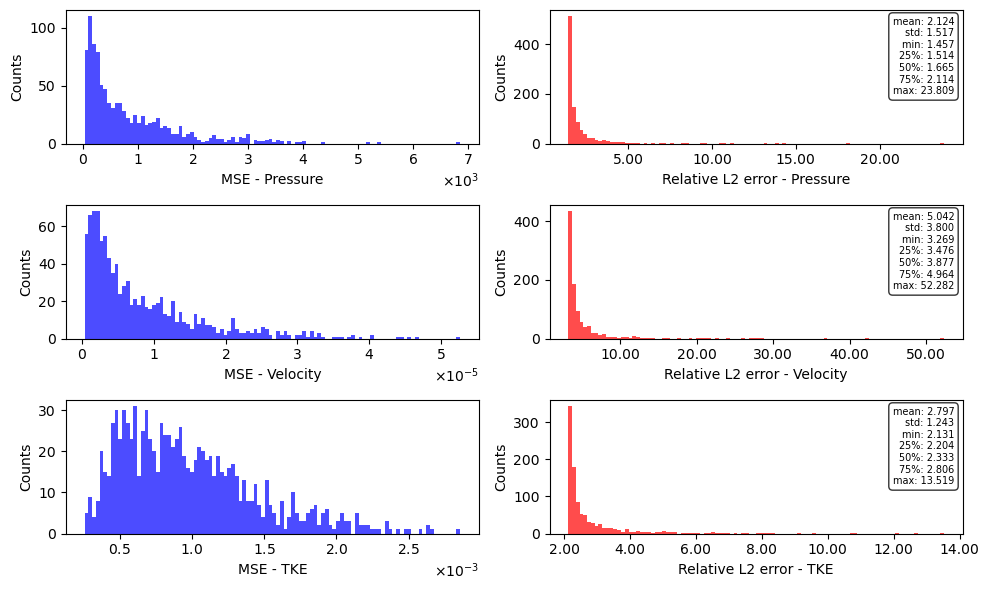

In [89]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

fig, ax = plt.subplots(3, 2, figsize=(10, 6))

channel_names = ['Pressure', 'Velocity', 'TKE']
mse_labels = [f"MSE - {name}" for name in channel_names]
rel_labels = [f"Relative L2 error - {name}" for name in channel_names]

# Create DataFrame from relative errors (in %)
df = pd.DataFrame({
    'ch0': rel_err[:, 0] * 100,
    'ch1': rel_err[:, 1] * 100,
    'ch2': rel_err[:, 2] * 100,
})

for i in range(3):
    # MSE
    ax[i, 0].hist(mse_per_sample[:, i], bins=100, color='blue', alpha=0.7)
    ax[i, 0].set_xlabel(mse_labels[i])
    ax[i, 0].set_ylabel('Counts')
    # Set scientific notation for MSE axis
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 2))
    ax[i, 0].xaxis.set_major_formatter(formatter)

    # Relative L2
    ax[i, 1].hist(df[f'ch{i}'], bins=100, color='red', alpha=0.7)
    ax[i, 1].set_xlabel(rel_labels[i])
    ax[i, 1].set_ylabel('Counts')
    ax[i, 1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Format statistics (excluding 'count')
    stats = df[f'ch{i}'].describe().drop(['count'])
    stats_str = '\n'.join([f"{idx}: {val:.3f}" for idx, val in stats.items()])

    # Add stats box
    ax[i, 1].text(
        0.98, 0.95, stats_str,
        transform=ax[i, 1].transAxes,
        fontsize=7,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8)
    )

plt.tight_layout()
plt.show()